<a href="https://colab.research.google.com/github/hochschule-pforzheim/project-st23-team-f23/blob/main/2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datensatz vorbereiten - Dummies, Skalen

Im ersten Schritt wird der Datensatz aus dem ersten Notebook unter dem Namen 'maindf' geladen. Hier muss der Datensatz "1_Cleansing_Join" aus dem vorherigen Notebook reingeladen werden.

In [ ]:
import pandas as pd
#from google.colab import drive
#drive.mount('/content/drive')
#maindf = pd.read_csv("drive/MyDrive/Colab Notebooks/1_Cleansing_Join.csv")
#maindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI & ML/Projekt/1_Cleansing_Join_final.csv')

Mounted at /content/drive


Nach inhaltlicher Überlegung ist klar geworden, dass die Spalten 'arrival_date','departure_date', 'night_index' und 'arrival_date_week_number' für den Input von Klassifikationsmodellen irrelevant sind. Hiermit werden sie aus dem Dataframe gelöscht

In [ ]:
maindf = maindf.drop(columns=['arrival_date','departure_date', 'night_index', 'arrival_date_week_number'])

In [ ]:
maindf.isna().sum()

Im folgenden Schritt werden bereits alle binären Variablen auch zu solch einem Datentyp geändert.

In [ ]:
maindf['is_canceled'] = maindf['is_canceled'].astype('uint8')
maindf['is_repeated_guest'] = maindf['is_repeated_guest'].astype('uint8')
maindf['holiday_flag'] = maindf['holiday_flag'].astype('uint8')
maindf['agent'] = maindf['agent'].astype('uint8')


Nun müssen alle nicht ordinalen, kategoriellen Features zu dummy-Variablen umgebaut werden.

In [ ]:
maindf = pd.concat([
    maindf.drop(columns=['city']), # remove the columns we one-hot-encode
    pd.get_dummies(maindf.city, drop_first=True, prefix='city'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

In [ ]:
maindf = pd.concat([
    maindf.drop(columns=['distribution_channel']), # remove the columns we one-hot-encode
    pd.get_dummies(maindf.distribution_channel, drop_first=True, prefix='distribution_channel'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

In [ ]:
maindf = pd.concat([
    maindf.drop(columns=['deposit_type']), # remove the columns we one-hot-encode
    pd.get_dummies(maindf.deposit_type, drop_first=True, prefix='deposit_type'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

In [ ]:
maindf = pd.concat([
    maindf.drop(columns=['customer_type']), # remove the columns we one-hot-encode
    pd.get_dummies(maindf.customer_type, drop_first=True, prefix='customer_type'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

In [ ]:
maindf

Das Feature country entpuppt sich als Problem, da hier über 175 dummy variablen gebildet werden würden

In [ ]:
len(maindf.country.value_counts())

Wir sehen aber bereits bei folgender Ansicht dass sich die meisten Buchungen höchstwahrscheinlich auf einige wenige Länder fokussieren werden.

In [ ]:
maindf.country.value_counts()

In [ ]:
maindf.groupby(['country']).sum()

Hier dann noch mal eine Ansicht aller Länder mit ihrer dazugehörigen Anzahl an Buchungen. Wir sehen dass relativ schnell schon keine vierstelligen Buchungsanzahlen mehr vorhanden sind. Aufgrundessen werden alle Länder aus dem Datensatz geworfen die n<1000 Buchungen aufweisen. Dieser modifizierte Dataframe wird maindf_c genannt

In [ ]:
country_counts = maindf['country'].value_counts()
country_names = country_counts.index.tolist()
counts = country_counts.tolist()

result = list(zip(country_names, counts))
print(result)

In [ ]:
keep_countries = ['PRT', 'GBR', 'Fra', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'USA', 'NLD', 'CHE', 'CN', 'AUT', 'SWE']
maindf_c = maindf[maindf['country'].isin(keep_countries)]

Mit folgenden 2 Zeilen sehen wir, dass gut 20000 Einträge durch diesen Schritt verloren gehen. Anschließend können jedoch Dummies gebildet werden und es sind anstatt 175 nur noch 14

In [ ]:
len(maindf)

In [ ]:
len(maindf_c)

In [ ]:
maindf_c = pd.concat([
    maindf_c.drop(columns=['country']), # remove the columns we one-hot-encode
    pd.get_dummies(maindf_c.country, drop_first=True, prefix='country'),
], axis=1) # join the one-hot-encoded columns by concatenating them side-by-side (axis 1)

In [ ]:
maindf_c.isna().sum()

In [ ]:
maindf_c

Da der 'arrival_date_month' noch in einem String vorliegt, werden die Werte nun durch die Monatszahlen ausgetauscht um eine bessere Verarbeitung durch das spätere Modell zu gewährleisten.

In [ ]:
arrival_date_month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
maindf_c.arrival_date_month = maindf_c.arrival_date_month.apply(lambda x: arrival_date_month_mapping[x])

wir sehen dass alle features in dem gewünschten Datenformat vorliegen, nur children erklärt sich uns nicht ganz.

In [ ]:
maindf_c.dtypes

Da, wie hier zu sehen lediglich integer-Werte in der 'children' Spalte vorhanden sind, wird das Datenformat auch zu diesem geändert.

In [ ]:
maindf_c.children.value_counts()

In [ ]:
maindf_c['children'] = maindf_c['children'].astype('int64')


Zudem werden zwei dummies umbenannt, damit später keine Probleme durch dessen Namen aufkommen. Bei beiden sind Satzzeichen vorhanden, mit denen Python in gewissen Codeausführungen nicht umgehen kann. Es wird das Leerzeichen, sowie das slash zu einem Unterstrich geändert. Somit haben wir bei allen features einen zusammenhängenden string.

In [ ]:
maindf_c= maindf_c.rename(columns={'deposit_type_Non Refund': 'deposit_type_Non_Refund'})


In [ ]:
maindf_c= maindf_c.rename(columns={'distribution_channel_TA/TO': 'distribution_channel_TA_TO'})


In [ ]:
maindf_c.isna().sum()

Wenn wir uns die durchschnittlichen Features, gruppiert nach den Ausprägungen unserer Zielvariablen anschauen, kann man schon erste kleine Ableitungen erkennen. Beispielsweise ist im Schnitt die Leadtime deutlich höher bei den Buchungen, welche gecancelt werden.

In [ ]:
maindf_c.groupby('is_canceled').mean()

Um Multikollinearität ausschließen zu können wird der VIF-Faktor für die Features berechnet.

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for regression model using 'rating' as response variable
yy, XX = dmatrices('is_canceled ~ lead_time+arrival_date_year+arrival_date_month+arrival_date_day_of_month+stays_in_weekend_nights+stays_in_week_nights+stay_nights_sum+adults+children+babies+is_repeated_guest+previous_cancellations+previous_bookings_not_canceled+booking_changes+agent+days_in_waiting_list+adr+total_of_special_requests+average_temperature+average_temp_min+average_temp_max+average_prcp+holiday_flag+city_Lisbon+distribution_channel_Direct+distribution_channel_GDS+distribution_channel_TA_TO+distribution_channel_Undefined+deposit_type_Non_Refund+deposit_type_Refundable+customer_type_Group+customer_type_Transient+customer_type_Transient-Party+country_BEL+country_BRA+country_CHE+country_CN+country_DEU+country_ESP+country_GBR+country_IRL+country_ITA+country_NLD+country_PRT+country_SWE+country_USA', data=maindf_c, return_type='dataframe')

#create DataFrame to hold VIF values
vif_df = pd.DataFrame()
vif_df['variable'] = XX.columns

#calculate VIF for each predictor variable
vif_df['VIF'] = [variance_inflation_factor(XX.values, i) for i in range(XX.shape[1])]

#view VIF for each predictor variable
print(vif_df)

# Prüfung auf Multikollinearität

Nun wird der VIF-Wert in ein anderes Format gebracht, um eine einfachere Interpretation zu gewährleisten. Vor allem die Features, welche die Temperatur abbilden zeigen einen extrem hohen VIF-Wert, was auch vollkommen logisch ist. Sie sind stark voneinander abhängig. Darum wird entschieden für die Temperatur lediglich die 'average_temperature' zu behalten.

In [ ]:
# Funktion zur Formatierung der Zahlen
def format_number(num):
    return "{:.8f}".format(num)

# Anwendung der Funktion auf die Spalte 'Zahlen'
vif_df['VIF'] = vif_df['VIF'].apply(format_number)

# Ausgabe des formatierten DataFrames
print(vif_df)

In [ ]:
maindf_c = maindf_c.drop(columns=['average_temp_min', 'average_temp_max'])

In [ ]:
maindf_c = maindf_c.drop(columns=['stays_in_week_nights', 'stays_in_weekend_nights'])

Hier wird der vorbereitete Datensatz als csv-Datei heruntergeladen, damit im nächsten Notebook für die Regression darauf zurückgegriffen werden kann.

In [ ]:
maindf_c.to_csv('2_Data_for_Modeltraining.csv', header=True, index=False)

# Skalieren und Explorieren des Datensatzes

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
maindf_scaled = maindf_c.copy()
columns_to_scale = list(set(maindf_c.columns) - {'is_canceled'}) # take all columns except Loan_Status_Y
maindf_scaled[columns_to_scale] = scaler.fit_transform(maindf_c[columns_to_scale])

In [ ]:
encoded_columns = ['is_canceled','arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month', 'agent', 'is_repeated_guest', 'holiday_flag', 'city_Lisbon', 'distribution_channel_Direct', 'distribution_channel_GDS', 'distribution_channel_Undefined', 'distribution_channel_TA_TO', 'deposit_type_Non_Refund', 'deposit_type_Refundable', 'customer_type_Group', 'customer_type_Transient', 'customer_type_Transient-Party',
       'country_BEL', 'country_BRA', 'country_CHE', 'country_CN', 'country_DEU', 'country_ESP', 'country_GBR', 'country_IRL', 'country_ITA', 'country_NLD', 'country_PRT', 'country_SWE', 'country_USA']
numerical_columns = list(set(maindf_c.columns) - set(encoded_columns))

In [ ]:
import matplotlib.pyplot as plt
for column in encoded_columns:
  fig = plt.figure() # required if we want to plot multiple figures from the same cell
  maindf_c[column].value_counts(sort=False).sort_index().plot(kind='bar', title=column)

In [ ]:
for column in numerical_columns:
  maindf_c.plot(kind='hist', y=column)

In [ ]:
import seaborn as sns
# .corr() calculates the correlation between each column in our dataframe
sns.heatmap(maindf_c.corr(), annot=False, cmap='coolwarm')

In [ ]:
X = maindf_c.drop(columns='is_canceled')
y = maindf_c.is_canceled

In [ ]:
X_scaled = maindf_scaled.drop(columns='is_canceled')
y_scaled = maindf_scaled.is_canceled

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, stratify = y_scaled, shuffle = True)

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train,y_train)
X_scaled_smote, y_scaled_smote = smote.fit_resample(X_train_scaled,y_train_scaled)

In [ ]:
columns = X_train.columns

X_scaled_smote = pd.DataFrame(data=X_scaled_smote, columns=columns)
y_scaled_smote = pd.DataFrame(data=y_scaled_smote, columns=['is_canceled'])

print("length of oversampled data is ",len(X_scaled_smote))
print("Number of no cancellation in oversampled data",len(y_scaled_smote[y_scaled_smote['is_canceled']==0]))
print("Number of cancellation",len(y_scaled_smote[y_scaled_smote['is_canceled']==1]))

In [ ]:
from sklearn.metrics import classification_report
def evaluate(clf, X_test_scaled, y_true):
  y_pred = clf.predict(X_test_scaled)
  print(classification_report(y_true, y_pred))

# Regressionsmodelle

## Logistische Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic = LogisticRegression(random_state=56)

In [ ]:
logistic.fit(X_scaled_smote, y_scaled_smote)

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=logistic)#, n_features_to_select=10)

rfe.fit(X_scaled_smote, y_scaled_smote)


selected_features = pd.DataFrame({'Feature': X_scaled_smote.columns, 'Selected': rfe.support_, 'Ranking': rfe.ranking_})
print(selected_features)

In [ ]:
ranking = pd.DataFrame({'Feature': X_scaled_smote.columns, 'Ranking': rfe.ranking_})
ranking = ranking.sort_values('Ranking')
print(ranking)

In [ ]:
evaluate(logistic, X_test_scaled, y_test_scaled)

In [ ]:
logistic.score(X_test_scaled, y_test_scaled)

### Explorieren der Predictions

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    logistic, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Booking cancelled', 'Booking not canceled'])

In [ ]:
predictions = logistic.predict(X_test_scaled)
df_with_predictions = pd.concat([X_test, y_test], axis='columns')
df_with_predictions = pd.concat([df_with_predictions, pd.DataFrame(predictions, columns=['Prediction'], index=df_with_predictions.index)], axis=1)

In [ ]:
misclassified_df = df_with_predictions[df_with_predictions.is_canceled != df_with_predictions.Prediction]

In [ ]:
misclassified_df

In [ ]:
for column in encoded_columns:
  fig, (ax1, ax2) = plt.subplots(1, 2) # required if we want to plot multiple figures from the same cell
  df_with_predictions[column].value_counts(sort=False).sort_index().plot(kind='bar', title=f'{column} (All)', ax=ax1)
  misclassified_df[column].value_counts(sort=False).sort_index().plot(kind='bar', title=f'{column} (Misclassified)', ax=ax2)

In [ ]:
for column in numerical_columns:
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
  df_with_predictions.plot(kind='hist', y=column, title=f'{column} (All)', ax=ax1)
  misclassified_df.plot(kind='hist', y=column, title=f'{column} (Misclassified)', ax=ax2)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logistic_roc_auc = roc_auc_score(y_test, logistic.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logistic_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Feature Importance und Variablen-Reduktion

In [ ]:
# Get feature importance
feature_importance = abs(logistic.coef_[0])

# Create a DataFrame with feature importance
importance_df = pd.DataFrame({'Feature': X_scaled_smote.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the resulting DataFrame
print(importance_df)

In [ ]:
less_features_df = maindf_c.drop(columns=['average_prcp', 'babies', 'agent', 'days_in_waiting_list', 'children', 'holiday_flag', 'stay_nights_sum', 'adults', 'average_temperature', 'customer_type_Group', 'distribution_channel_Undefined', 'country_CN', 'deposit_type_Refundable', 'country_SWE', 'country_NLD', 'country_BEL', 'distribution_channel_GDS', 'country_DEU', 'country_CHE', 'customer_type_Transient-Party', 'country_GBR', 'country_USA'])

In [ ]:
new_X = less_features_df.drop(columns='is_canceled')
new_y = less_features_df.is_canceled

In [ ]:
new_X_scaled = less_features_df.drop(columns='is_canceled')
new_y_scaled = less_features_df.is_canceled

In [ ]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify = new_y, shuffle = True)
new_X_train_scaled, new_X_test_scaled, new_y_train_scaled, new_y_test_scaled = train_test_split(new_X_scaled, new_y_scaled, test_size=0.2, random_state=42, stratify = new_y_scaled, shuffle = True)

In [ ]:
new_smote = SMOTE(random_state=42)
new_X_smote, new_y_smote = smote.fit_resample(new_X_train,new_y_train)
new_X_scaled_smote, new_y_scaled_smote = smote.fit_resample(new_X_train_scaled,new_y_train_scaled)

In [ ]:
def new_evaluate(clf, new_X_test, new_y_true):
  new_y_pred = clf.predict(new_X_test)
  print(classification_report(new_y_true, new_y_pred))

In [ ]:
new_logistic = LogisticRegression(random_state=56)

In [ ]:
new_logistic.fit(new_X_scaled_smote, new_y_scaled_smote)

In [ ]:
new_evaluate(new_logistic, new_X_test_scaled, new_y_test_scaled)

In [ ]:
new_logistic.score(new_X_test_scaled, new_y_test_scaled)

### Hyperparametertuning

In [ ]:
from scipy.stats import loguniform

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_scaled, y_scaled)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on your data
y_pred = best_model.predict(X_scaled)
print("Classification Report:")
print(classification_report(y_scaled, y_pred))


In [ ]:
def hyper_evaluate(clf, X_test, y_true):
  hyper_y_pred = clf.predict(X_test)
  print(classification_report(y_true, hyper_y_pred))

Mit dem Parameter l2 wird die sogenannte L2-Regulierung angewandt und verringert so die Gefahr vor Overfitting stark, da die Komplexität des Modells reduziert wird und somit weniger anfällig für overfitting ist. Das Modell wird bestraft wenn es große Koeffizienten verwendet. Die Koeffizienten werden während des Trainingsprozesses kleiner gehalten.

In [ ]:
hyper_logistic = LogisticRegression(random_state=56, C=0.1, penalty='l2', solver='liblinear')

In [ ]:
hyper_logistic.fit(X_scaled_smote, y_scaled_smote)

In [ ]:
hyper_evaluate(hyper_logistic, X_test_scaled, y_test_scaled)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train_scaled, y_train_scaled)

In [ ]:
y_pred = knn.predict(X_test_scaled)


from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test_scaled, y_pred))

In [ ]:
evaluate(knn, X_test_scaled, y_test_scaled)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    knn, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Booking cancelled', 'Booking not canceled'])

## Hyperparametertuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

ht = RandomizedSearchCV(knn, param_grid, random_state=42, n_iter=10)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [ ]:
# fit the model on our train set
g_res = gs.fit(X_train_scaled, y_train_scaled)

In [ ]:
# find the best score
g_res.best_score_

In [ ]:
# get the hyperparameters with the best score
ht_params=g_res.best_params_
ht_params

In [ ]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train_scaled, y_train_scaled)

In [ ]:
# get a prediction
y_hat = knn.predict(X_train_scaled)
y_knn = knn.predict(X_test_scaled)

In [ ]:
evaluate(g_res, X_test_scaled, y_test_scaled)

# **Support Vector Machines**

https://www.inovex.de/de/blog/support-vector-machines-guide/

https://scikit-learn.org/stable/modules/svm.html
https://dataaspirant.com/svm-kernels/#t-1608140512020

SVC gar nicht gut für große Samples https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html, herausgefunden, nachdem lange gedauert und abgebrochen.

Support Vector Machines sind im Machine Learning weit verbreitete Algorithmen, insbesondere für Klassifikationsaufgaben. Dabei kann über den Parameter 'kernel' bestimmt werden, durch welche Funktionsform die Klassen gebildet werden (linear, rbf, polynomial). Für große Datenmengen, wie sie in unserem Fall vorliegen, eignen sich die Standard-SVCs leider nicht, wir benötigen die schnellere Implementierung, den LinearSVC. Dieser Classifier akzeptiert allerdings den Parameter 'kernel' nicht bzw. der Parameter muss nicht definiert werden.

Wir importieren den LinearSVC aus dem sklearn.svm-package, trainieren das Modell und evaluieren das gefittete Modell.

In [ ]:
# for LinearSVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

# for predicting labels
from sklearn.metrics import accuracy_score, recall_score, precision_score

#for Hyperparameter Tuning
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

#for Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X, y = make_classification(n_features=4, random_state=42)
svc_clf = LinearSVC(random_state=42, tol=1e-5)

svc = svc_clf.fit(X_train_scaled, y_train_scaled)

In [ ]:
y_svc_predict = svc_clf.predict(X_test_scaled)
y_svc_predict = y_svc_predict.reshape(-1,1)

In [ ]:
evaluate(svc, X_test_scaled,y_test_scaled)

Über die Confusion Matrix können wir nun darstellen, wie häufig bestimmte Werte predictet wurden und stellen diese den tatsächlich eingetretenen Fällen gegnüber.

In [ ]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test_scaled, y_svc_predict))

> true positive (TP) predictions

> true negative (TN) predictions

> false positive (FP) predictions

> false negative (FN) predictions

> The decision tree **correctly** predicted 11,617 instances as negative (TN) and 6,703 instances as positive (TP).

> The decision tree made 2,101 **false** positive predictions (FP) and 1,862 false negative predictions (FN).

Noch übersichtlicher werden die Ergebnisse der Confusion Matrix in einem Plot.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    svc, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Not canceled', 'Canceled'])

## **Hyperparameter Tuning**

C: da LinearSVC: andere Parameter wie 'learning_rate' nicht valid.

Die Fehlermeldung "TypeError: Parameter grid for parameter 'C' is not iterable or a distribution (value=1)" deutet darauf hin, dass es ein Problem mit dem angegebenen Parameterraum für den Parameter 'C' gibt. Der Wert '1' allein ist nicht als Parameterraum gültig.

Um das Problem zu beheben, kannst du entweder einen spezifischen Wert oder einen Parameterraum für 'C' angeben. Hier sind zwei Möglichkeiten:

from scipy.stats import uniform

param_grid = {
    'C': uniform(loc=0.1, scale=10),

    Die Wahl zwischen der Verwendung spezifischer Werte und der Verwendung eines Parameterraums hat Vor- und Nachteile, die ich im Folgenden erläutern werde:

Option 1: Spezifische Werte für 'C':
Vorteile:

Einfachheit: Die Verwendung spezifischer Werte ist einfach und erfordert keine weiteren Berechnungen.
Kontrolle: Du hast direkte Kontrolle über die ausgewählten Werte für 'C' und kannst gezielt bestimmte Werte testen.
Nachteile:

Möglicher Informationsverlust: Es besteht die Möglichkeit, dass der optimale Wert für 'C' nicht in den spezifischen Werten enthalten ist. Dies kann dazu führen, dass das Tuning nicht das bestmögliche Ergebnis erzielt.
Option 2: Parameterraum für 'C':
Vorteile:

Flexibilität: Durch die Verwendung eines Parameterraums kannst du einen breiteren Bereich von 'C'-Werten abdecken und somit eine größere Chance haben, den optimalen Wert zu finden.
Automatisierte Suche: Der Hyperparameter-Tuning-Algorithmus (z. B. RandomizedSearchCV) kann den Parameterraum automatisch durchsuchen und die besten Kombinationen finden.
Nachteile:

Komplexität: Die Definition eines Parameterraums erfordert möglicherweise zusätzliche Überlegungen und Kenntnisse über die Wertebereiche von 'C'. Die Auswahl eines geeigneten Parameterraums kann eine gewisse Erfahrung oder Experimentation erfordern.
Berechnungsaufwand: Ein breiterer Parameterraum kann zu einer erhöhten Rechenzeit führen, da der Hyperparameter-Tuning-Algorithmus mehr Kombinationen ausprobieren muss.
Es ist wichtig zu beachten, dass die Vor- und Nachteile von Optionen wie spezifischen Werten oder Parameterräumen stark vom Anwendungsfall und den Eigenschaften des Modells abhängen können. Es empfiehlt sich, verschiedene Optionen auszuprobieren und die Auswirkungen auf die Leistung des Modells zu beobachten, um die besten Hyperparameter-Tuning-Strategien zu ermitteln.



In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'dual': [True, False],
    'fit_intercept': [True, False],
    'intercept_scaling': loguniform(0.1, 10),
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [100, 500, 1000],
    'penalty': ['l1', 'l2'],
    'tol': loguniform(0.0001, 0.1),
    'verbose': [0, 1]
}

In [ ]:
ht_svc = RandomizedSearchCV(svc_clf, param_grid, random_state=42, n_iter=10)

In [ ]:
ht_svc.fit(X_train_scaled, y_train_scaled)

Trotz Hyperparameter Tuning richtig schlechte Accuracy => nicht geeignet

In [ ]:
ht_svc.best_params_

In [ ]:
evaluate(ht_svc, X_test_scaled, y_test_scaled)

# Decision Tree

> Im Folgenden wollen wir eine Classification mithilfe eines Decision Trees durchführen. Wir beginnen, indem wir alle für die Analyse notwendigen Funktionen einlesen.

In [ ]:
# importing relevant functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics

> Wir definieren unser Classification-Methode als DecisionTreeClassifier.

In [ ]:
# defining the classification model
tree = DecisionTreeClassifier(random_state=42)

> Im nächsten Schritt trainieren wir das Modell auf den Trainingsdaten.

In [ ]:
# training the model
tree.fit(X_train_scaled, y_train_scaled)

DecisionTreeClassifier(random_state=42)

> Wir lassen uns die Targetvariable auf Basis der Testdaten vorhersagen.

In [ ]:
# predicting the target for the test data
y_test_pred = tree.predict(X_test_scaled)

> Evaluieren wir zuerst die Performance des Models auf Basis der Trainingsdaten erhalten wir eine Accuracy von 0.99.

> Daraus schließen wir, dass das Modell bei den Trainingsdaten außergewöhnlich gut funktioniert und die dort vorhandenen Muster sehr gut anpassen oder speichern kann. Wir sprechen hier von Overfitting.

> Um diese Annahme zu bestätigen, lassen wir uns im zweiten Schritt die Performance des Models auf Basis der Testdaten ausgeben.

In [ ]:
# evaluating the performance of the train data
evaluate(tree, X_train_scaled, y_train_scaled)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42679
           1       1.00      0.99      0.99     30052

    accuracy                           0.99     72731
   macro avg       1.00      0.99      0.99     72731
weighted avg       0.99      0.99      0.99     72731



> Hier erhalten wir eine Accuracy von 0.84. Die Leistung des Modells ist bei den Testdaten also deutlich geringer im Vergleich zu den Trainingsdaten. Diese Diskrepanz deutet darauf hin, dass das Modell nicht gut auf neue Beispiele verallgemeinert und bestätigt unsere Annahme des Overfittings.

In [ ]:
# evaluating the performance of the test data
evaluate(tree, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86     10670
           1       0.80      0.81      0.80      7513

    accuracy                           0.84     18183
   macro avg       0.83      0.83      0.83     18183
weighted avg       0.84      0.84      0.84     18183



> Den Accuracy Score von 0.84 sehen wir als vergleichsweise gutes Ergebnis an, werden aber im weiteren Verlauf versuchen, ihn durch Hyperparameter Tuning weiter zu optimieren.

## Hyperparameter Tuning

> Um unser Decision-Tree-Modell zu optimieren, führen wir im nächsten Schritt das Hyperparameter Tuning durch.

> Wir definieren erneut unsere Classification-Methode, allerdings ohne bereits einen 'random_state' vorzugeben.

In [ ]:
# defining the classification model
tree = DecisionTreeClassifier()

### RandomizedSearchCV

> Zu aller erst wollen wir wissen, welche Parameter sich aktuell im Decision Tree Classifier befinden und uns damit für das Hyperparameter Tuning zur erfügung stehen.

In [ ]:
# Explore parameters used by the current decision tree

from pprint import pprint

print('Parameters currently in use:\n')
pprint(tree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}


> Wir erstellen ein Grid, in dem wir für alle relevanten Parameter einen Suchbereich bestimmen.Dieser enthält definierte Optionen, die durchgetestet werden sollen und anhand derer die optimale Parametereinstellung gefunden werden soll.

In [ ]:
from scipy.stats import loguniform

param_grid = {
    'criterion': ['entropy','gini','log_loss'],
    'splitter': ['best','random'],
    'max_depth': [None,3, 5, 7, 9],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [4, 5, 7, 9, 11, 13,'log2','sqrt',None],
    'random_state': [None, 21, 42]
}

> Wir definieren unsere Methode als RandomizedSearchCV.

In [ ]:
# creating a randomized search instance

from sklearn.model_selection import RandomizedSearchCV

ht = RandomizedSearchCV(tree, param_grid, n_iter=10)

In [ ]:
ht.fit(X_train_scaled, y_train_scaled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['entropy', 'gini',
                                                      'log_loss'],
                                        'max_depth': [None, 3, 5, 7, 9],
                                        'max_features': [4, 5, 7, 9, 11, 13,
                                                         'log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'random_state': [None, 21, 42],
                                        'splitter': ['best', 'random']})

In [ ]:
ht.best_params_

{'splitter': 'random',
 'random_state': None,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': None,
 'criterion': 'gini'}

In [ ]:
evaluate(ht, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     10670
           1       0.83      0.76      0.79      7513

    accuracy                           0.83     18183
   macro avg       0.83      0.82      0.83     18183
weighted avg       0.83      0.83      0.83     18183



> Die Accuracy unseres Models ist nach dem Hyperparameter Tuning etwas niedriger als zuvor.

### GridSearchCV

> Wir versuchen uns an einer Alternative zum RandomizedSearchCV: dem GridSearchCV.

> Dafür passen wir die Parameter in unserem Search Grid an bzw. minimiren ihren Umfang. Grund hierfür ist die hohe Komplexität und lange Laufzeit des Fittings.

In [ ]:
param_grid = {
    'criterion': ['entropy','gini','log_loss'],
    'max_depth': [None,3, 5, 7, 9],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 2, 4, 6],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

ht = GridSearchCV(tree, param_grid, n_jobs=2)

In [ ]:
ht.fit(X_train_scaled, y_train_scaled)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [None, 3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 3, 5, 7]})

In [ ]:
ht.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

In [ ]:
evaluate(ht, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     10670
           1       0.81      0.81      0.81      7513

    accuracy                           0.84     18183
   macro avg       0.83      0.83      0.83     18183
weighted avg       0.84      0.84      0.84     18183



> Wir erhalten mit GridSearchCV eine Accuracy identisch zu unserem Modell vor dem Hyperparameter Tuning.

## Finaler Decision Tree

In [ ]:
tree = DecisionTreeClassifier(
    splitter='best',
    random_state=42,
    min_samples_split=7,
    min_samples_leaf=4,
    max_features=None,
    max_depth=None,
    criterion='entropy')

In [ ]:
tree.fit(X_train_scaled, y_train_scaled)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=7, random_state=42)

In [ ]:
y_pred = tree.predict(X_test_scaled)

In [ ]:
evaluate(tree, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86     10670
           1       0.82      0.78      0.80      7513

    accuracy                           0.84     18183
   macro avg       0.83      0.83      0.83     18183
weighted avg       0.84      0.84      0.84     18183



> Wenn wir uns den Confusion Matrix ausgeben lassen erkennen wir, dass eine sehr ähnliche Anzahl an Fehlern 'False Positive' und 'False Negative' sind. Es besteht demnach nur ein sehr geringer Unterschied zwischen den falschen Vorhersagen einer stornierten und einer nicht-storierten Buchung.

In [ ]:
# printing the confusion matrix
print(confusion_matrix(y_test_scaled, y_pred))

[[9344 1326]
 [1654 5859]]


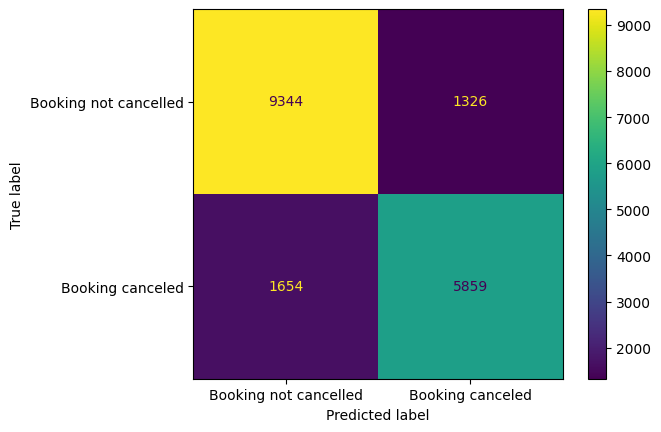

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    tree, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Booking not cancelled', 'Booking canceled'])

> Wir möchten uns den Decision Tree visualisieren lassen, um direkt ablesen zu können, wo das Modell die Schwellenwerte der einzelnen Variablen setzt, die entscheiden, ob eine Buchung storniert wird oder nicht.

> Vorerst werden die erforderlichen Pakete installiert.

> Wir begrenzen die Visualisierung auf eine Breite von 25 Pixeln und eine Höhe von 20 Pixeln.

> Der Baum soll sich außerdem auf maximal 4 abzweigende Ebenen beschränken und mit einer Schriftgröße von 12 angezeigt werden. Die Features sollen analog zu den Variablen und die letztendlichen Klassen analog zu dem Fakt Keine Stornierung/Stornierung betitelt werden.

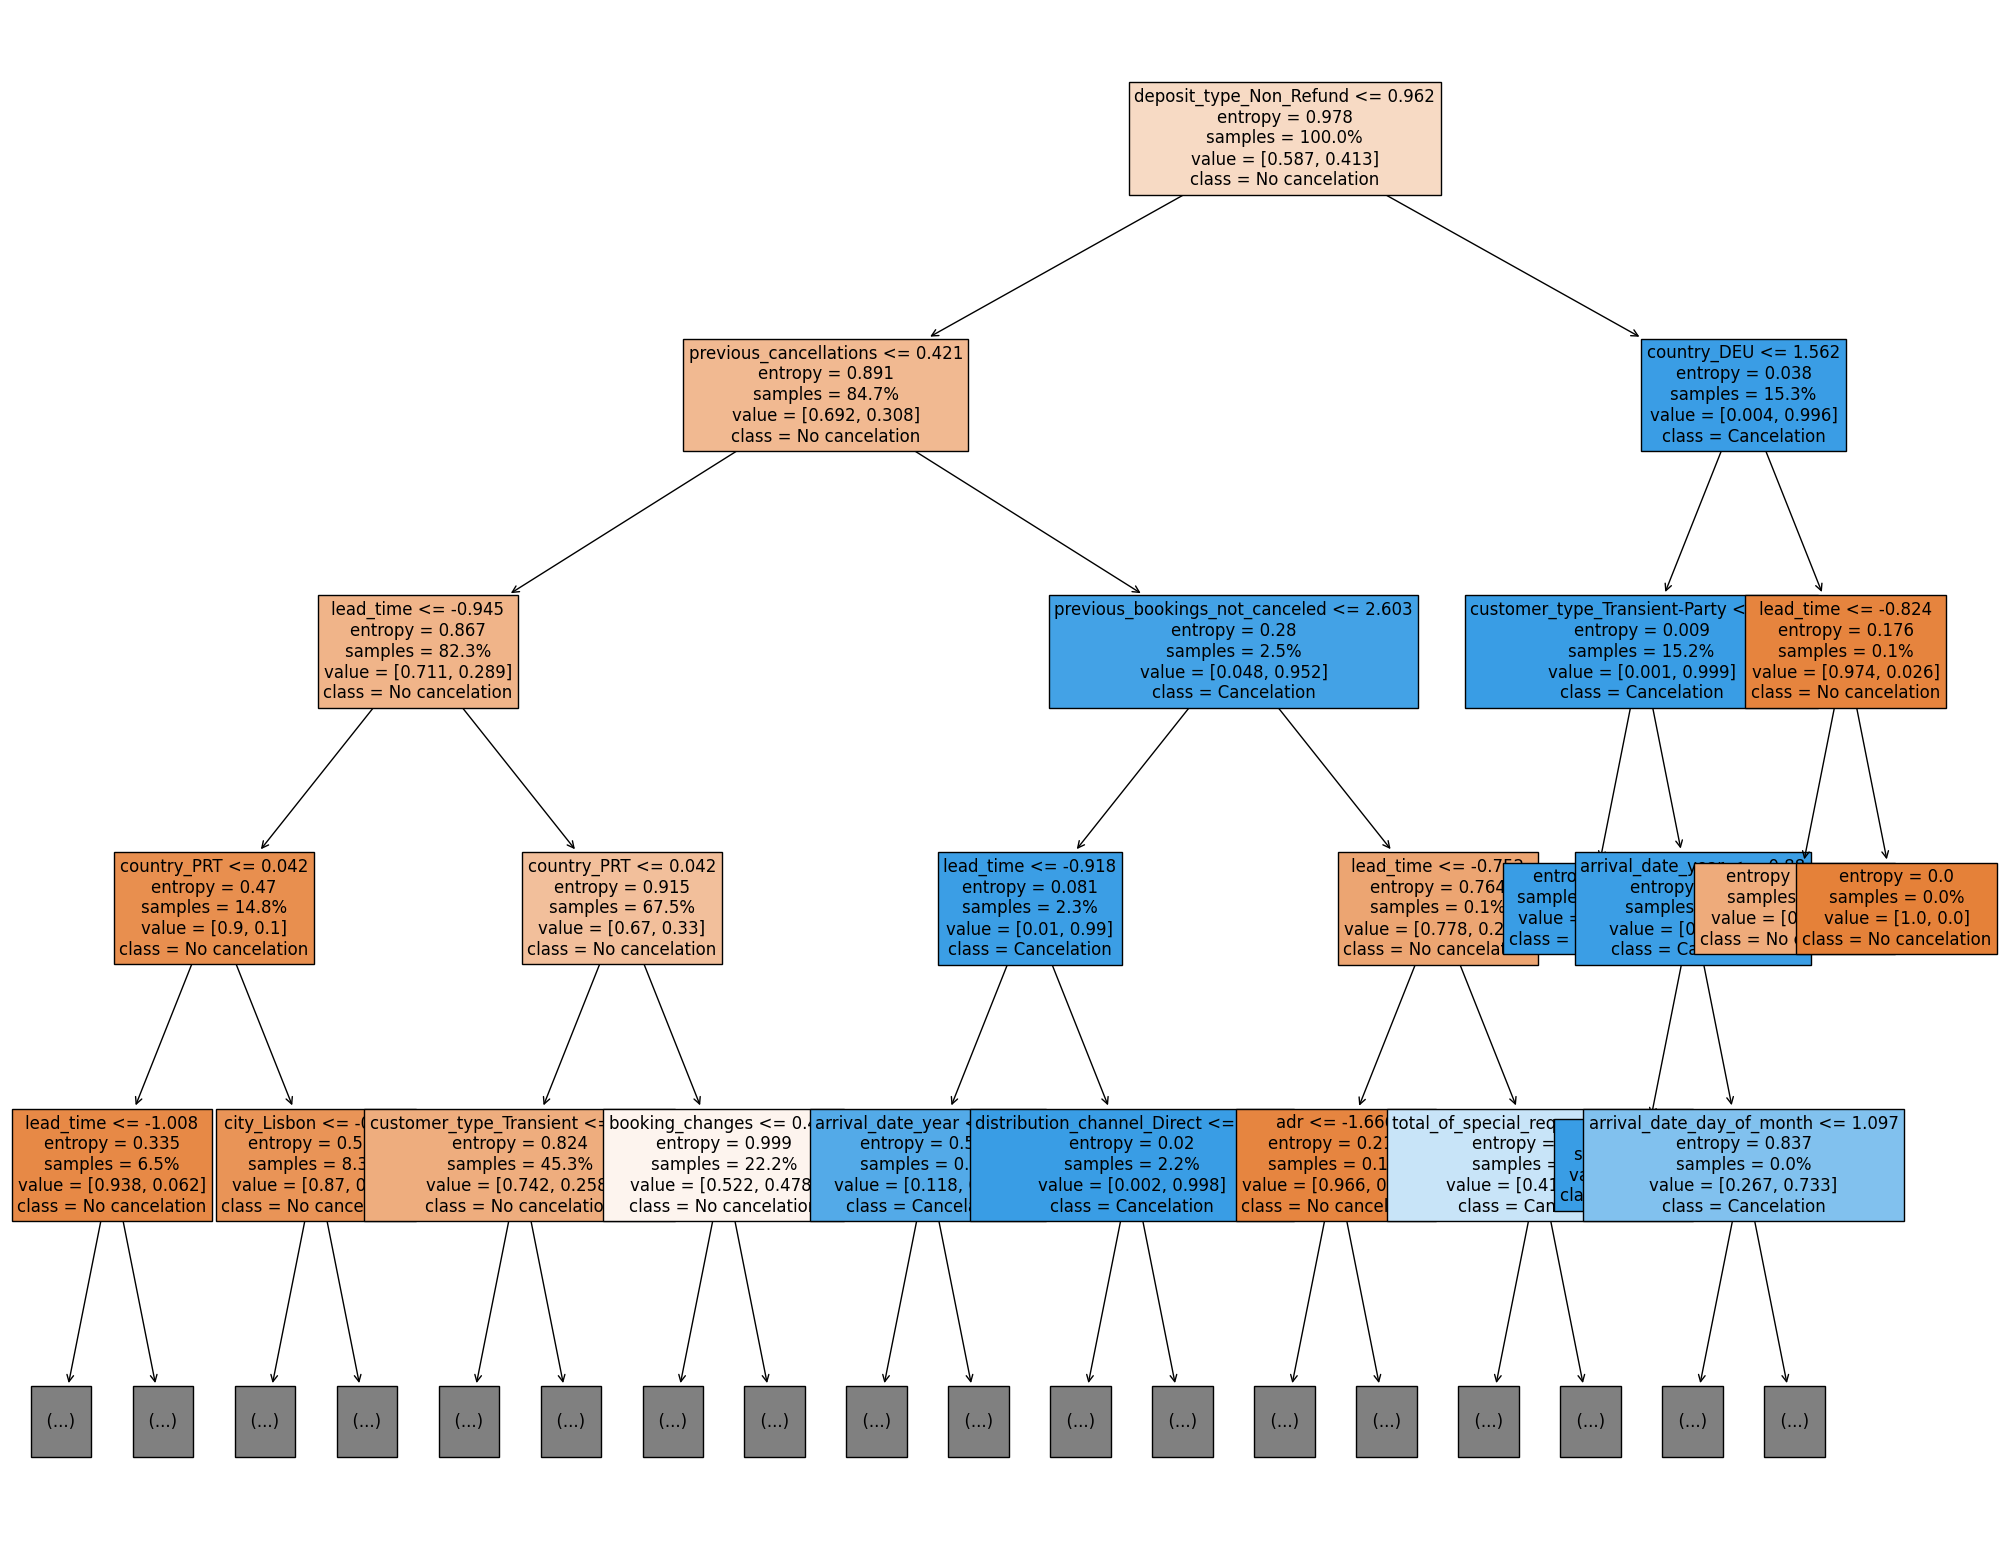

In [ ]:
from sklearn import tree as sktree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,20))

sktree.plot_tree(tree,
                 max_depth=4,
                 fontsize=12,
                 feature_names=X.columns,
                 class_names=['No cancelation', 'Cancelation'],
                 proportion=True,
                 filled=True);

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(random_state=42)

In [ ]:
forest.fit(X_train_scaled, y_train_scaled)

RandomForestClassifier(random_state=42)

In [ ]:
y_test_pred_for = forest.predict(X_test_scaled)

 > Wie auch im Decision Tree erhalten wir beim Random Forest auf Basis der Trainingsdaten eine extrem hohe Accuracy von 0.99. Unsere Vermutung lautet Overfitting.

In [ ]:
# evaluating the performance of the train data
evaluate(forest, X_train_scaled, y_train_scaled)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42679
           1       1.00      0.99      0.99     30052

    accuracy                           0.99     72731
   macro avg       0.99      0.99      0.99     72731
weighted avg       0.99      0.99      0.99     72731



> Die deutliche niedrigere Accuracy von 0.88 auf Basis der Testdaten bestätigt unsere Annahme von Overfitting.

In [ ]:
# evaluating the performance of the test data
evaluate(forest, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10670
           1       0.89      0.80      0.84      7513

    accuracy                           0.88     18183
   macro avg       0.88      0.87      0.87     18183
weighted avg       0.88      0.88      0.88     18183



## Hyperparameter Tuning

> Um unser Random-Forest-Modell zu optimieren, führen wir im nächsten Schritt das Hyperparameter Tuning durch.

> Wir definieren erneut unsere Classification-Methode, allerdings ohne bereits einen 'random_state' vorzugeben.

In [ ]:
# defining the classification model
forest = RandomForestClassifier()

### RandomizedSearchCV

> Zu aller erst wollen wir wissen, welche Parameter sich aktuell im Random Forest Classifier befinden und uns damit für das Hyperparameter Tuning zur erfügung stehen.

In [ ]:
# Explore parameters used by the current forest

from pprint import pprint

print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


> Wir erstellen ein Grid, in dem wir für alle relevanten Parameter einen Suchbereich bestimmen. Dieser enthält definierte Optionen, die durchgetestet werden sollen und anhand derer die optimale Parametereinstellung gefunden werden soll.

In [ ]:
param_grid = {
    'bootstrap': [True],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None,3, 5, 7, 9],
    'max_features': [4, 5, 7, 9, 11, 13,'auto','sqrt','log2',None],
    'max_leaf_nodes': [10, 20, 30, 40, None],
    'max_samples': [1, 3, 5, 7, 9],
    'min_impurity_decrease': [0.0, 0.3, 0.7],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 3, 5, 7],
    'min_weight_fraction_leaf': [0.0, 0.3, 0.5],
    'n_estimators': [80, 100, 120],
    'oob_score': [True, False],
    'random_state': [None, 21, 42]
}

> Wir definieren unsere Methode als RandomizedSearchCV.

In [ ]:
# creating a randomized search instance

from sklearn.model_selection import RandomizedSearchCV

ht = RandomizedSearchCV(forest, param_grid, n_jobs=10)

In [ ]:
ht.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=10,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 3, 5, 7, 9],
                                        'max_features': [4, 5, 7, 9, 11, 13,
                                                         'auto', 'sqrt', 'log2',
                                                         None],
                                        'max_leaf_nodes': [10, 20, 30, 40,
                                                           None],
                                        'max_samples': [1, 3, 5, 7, 9],
                                        'min_impurity_decrease': [0.0, 0.3,
                                                                  0.7],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'min_weight_fraction_leaf': [0.0, 0.3,
                                                                     0.5],
                                        'n_estimators': [80, 100, 120],
                                        'oob_score': [True, False],
                                        'random_state': [None, 21, 42]})

In [ ]:
ht.best_params_

{'random_state': None,
 'oob_score': False,
 'n_estimators': 80,
 'min_weight_fraction_leaf': 0.3,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.3,
 'max_samples': 7,
 'max_leaf_nodes': 20,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'log_loss',
 'class_weight': 'balanced',
 'bootstrap': True}

In [ ]:
evaluate(ht, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.68      0.83      0.75     10670
           1       0.65      0.44      0.52      7513

    accuracy                           0.67     18183
   macro avg       0.66      0.63      0.63     18183
weighted avg       0.66      0.67      0.65     18183



> Nach dem Hyperparameter Tuning mit RandomizedSearchCV performt der Random Forest mit einer Accuracy von 0.74 deutlich schlechter als noch vorher.

### GridSearchCV

> Wir versuchen uns an einer Alternative zum RandomizedSearchCV: dem GridSearchCV.

> Dafür passen wir die Parameter in unserem Search Grid an bzw. minimiren ihren Umfang. Grund hierfür ist die hohe Komplexität und lange Laufzeit des Fittings.

In [ ]:
param_grid = {
    'max_features': [5, 9, 13,'log2',None],
    'max_leaf_nodes': [20, 40, None],
    'max_samples': [1, 3, 5, 7],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [3, 7],
    'n_estimators': [100, 120],
}

> Wir versuchen uns an einer Alternative zum RandomizedSearchCV: dem GridSearchCV.

In [ ]:
ht = GridSearchCV(forest, param_grid, n_jobs=2)

In [ ]:
ht.fit(X_train_scaled, y_train_scaled)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [5, 9, 13, 'log2', None],
                         'max_leaf_nodes': [20, 40, None],
                         'max_samples': [1, 3, 5, 7],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [3, 7],
                         'n_estimators': [100, 120]})

In [ ]:
ht.best_params_

{'max_features': None,
 'max_leaf_nodes': 40,
 'max_samples': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 120}

In [ ]:
evaluate(ht, X_test_scaled, y_test_scaled)

              precision    recall  f1-score   support

           0       0.68      0.99      0.80     10670
           1       0.95      0.33      0.49      7513

    accuracy                           0.72     18183
   macro avg       0.81      0.66      0.65     18183
weighted avg       0.79      0.72      0.68     18183



## Finaler Random Forest

In [ ]:
forest = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight=None,
    criterion='gini',
    max_depth=None, # wenn begrenzt, niedrigere accuracy
    max_features='sqrt',
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=None,
    oob_score=False,
    random_state=42,
    verbose=0,
    warm_start=False)

In [ ]:
forest.fit(X_train_scaled, y_train_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.1s finished


RandomForestClassifier(random_state=42, verbose=1)

In [ ]:
evaluate(forest, X_test_scaled, y_test_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10670
           1       0.89      0.80      0.84      7513

    accuracy                           0.88     18183
   macro avg       0.88      0.87      0.87     18183
weighted avg       0.88      0.88      0.88     18183



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [ ]:
y_pred = forest.predict(X_test_scaled)

> Lassen wir uns die Confusion Matrix einmal visualisieren, erkennen wir, dass nahezu doppelt so viele der falschen Vorhersagen angeben, eine Buchung würde nicht storniert, wenn sie in Wirklichkeit storniert wird.

In [ ]:
# printing the confusion matrix
print(confusion_matrix(y_test_scaled, y_pred))

[[8451 2219]
 [2543 4970]]


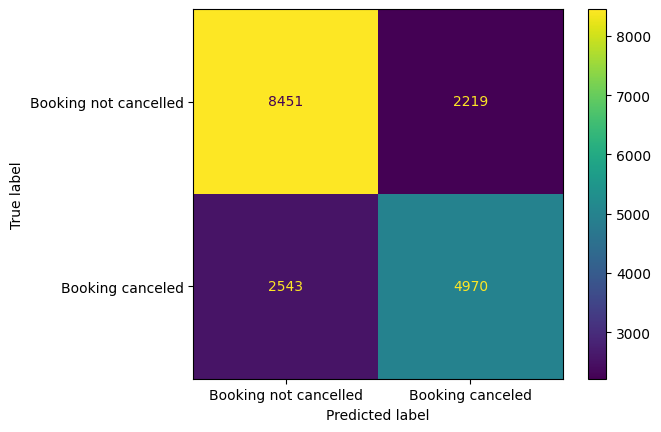

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    forest, X_test_scaled, y_test_scaled, labels=[0, 1], display_labels=['Booking not cancelled', 'Booking canceled'])

# **Gradient Boosting**



> Als nächstes Modell testen wir das additive Ensemble-Modell 'Gradient Boosting'. Hierbei werden schwächere Lernmodelle, i. d. R. Entscheindungsbäume schrittweise hinzugefügt und somit zu einem starken Lernmodell kombiniert. Im Gegensatz zum Random Forest werden beim Gradient Boosting gezielt schwache, fehlerhafte Lernmodelle genutzt, um diese zu kombinieren und Schwachstellen auszugleichen. Schritt für Schritt wird ein neues schwaches Lernmodell hinzugezogen und die Fehler korrigiert.

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting




> Für Gradient Boosting benötigen wir den GradientBoostingClassifier. Der Parameter 'n_estimators' des Classifiers beschreibt dabei die Anzahl an schwächeren Lernmodellen, die sukzessive ins Trainingsmodell mitaufgenommen werden. DIe 'learning_rate' gibt den Hyperparameter sn, durch den Overfitting vermieden werden soll, der also das gesamte Modell reguliert. die Größe des decision trees wird durch 'max_depth' definiert. Über den Hyperparameter 'random_state' wird bestimmt, dass train- und test-Daten immer die selben Werte annehmen und somit das Machine Learning Modell immer die gleichen Ergebnisse liefert.



> Um GradientBossting als Classification durchführen zu können, müssen wir erstmal den gradientBoostingClassifier aus sklearn.ensemble importieren.



In [ ]:
from numpy import loadtxt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

Wir bestimmen die Parameter n_estimators, learning_rate und max_depth entsprechend der Python-Dokumentation und bestimmen einen random_state, um immer gleiche Ergebnisse mit Training und Evaluation zu erhalten.

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=42)

In [ ]:
gb.fit(X_train_scaled, y_train_scaled)

Das trainierte Modell kann evaluiert werden. Wir sehen, dass die Accuracy bei 82% liegt, der f1-Score liegt knapp darunter, bei %.

In [ ]:
evaluate(gb, X_test_scaled, y_test_scaled)

## **Hyperparameter Tuning**

AUS SKRIPT

In [ ]:
param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': loguniform(0.001, 1),
    'n_estimators': [50, 100, 200, 220, 250],
    'subsample': [0.3, 0.5, 0.8, 1.0],
    'max_depth': [3, 5, 7, 11],
    'min_samples_split': [1, 2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
}

https://colab.research.google.com/drive/1alinCu_hm_69JQRA_jPoCB_PY3xnE7Br#scrollTo=2qVTsJxtk5Xg&line=4&uniqifier=1

In [ ]:
ht_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, random_state=42, n_iter=10)

In [ ]:
ht_gb.fit(X_train_scaled, y_train_scaled)

In [ ]:
ht_gb.best_params_

Ein bisschen nochmal verbessert. Ist i.O.

In [ ]:
evaluate(ht_gb, X_test_scaled, y_test_scaled)

# **XGBoost**

Das XGBoost-Modell ist eine spezielle Implementierung der Ensemble-Methode 'GradientBoosting', die sehr viele Etnscheidungsbäume trainiert, schrittweise miteinander kombiniert und durch Fehlerbeseitung der hinzugefügten Modelle optimiert. XGBoost steht dabei für 'Extreme Gradient Boosting', das optimierte Trainingsalgorithmen verwendet, Gradientenabstieg und Regularisierungstechniken kombiniert, um Overfitting zu reduzieren und ein leistungsstarkes, effizientes Gradient Bossting Modell zu bieten.
XGBoost hat sich daher besonders für Klassifikationen im Bereich Data Science bewährt, in dem große Datenmengen verarbeitet werden.

Ein Vorteil des XGBoost-Modells ist, dass im Gegensatz zu anderen Gradient Boosting-Implementierungen Regularisierungstechniken (L1- und L2-Regularisierung) integriert sind, sodass Overfitting reduziert und die Modellkomplexität gesteuert werden kann. Außerdem kann das Modell durch viele Parameter flexibel gestaltet werden und sich so an das Problem anpassen. Zuletzt punktet XGBoost auch mit guter Akalierbarkeit, was sich besonders für große Datensätze und viele Features - und somit für unseren Fall - gut eignet.

XGBoost performt meist sehr gut und erzielt eine hohe Accuracy.

Für die Implementierung importieren wir den XGBClassifier aus dem package 'xgboost' und definieren die Parameter 'objective', 'alpha' (Hyperparameter für die Stärke der L1-Regularisierung) und lambda (L2-Regularisierung). Danach kann das Modell trainiert und als Entscheidungsbaum geplottet werden.

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

params = {
    'objective': 'binary:logistic',
    'alpha': 0.5,    # L1-Regularisierung
    'lambda': 0.5    # L2-Regularisierung
}

xgb = XGBClassifier(**params)
xgb.fit(X_train_scaled, y_train_scaled)

plot_tree(xgb)
plt.show()

alpha (L1-Regularisierung): Der Hyperparameter alpha steuert die Stärke der L1-Regularisierung. Ein höherer Wert von alpha führt zu einer stärkeren Regularisierung und reduziert die Anzahl der Merkmale im Modell. Standardmäßig ist alpha=0, was bedeutet, dass keine L1-Regularisierung angewendet wird.

lambda (L2-Regularisierung): Der Hyperparameter lambda steuert die Stärke der L2-Regularisierung. Ein höherer Wert von lambda führt zu einer stärkeren Regularisierung und reduziert die Größe der Modellkoeffizienten. Standardmäßig ist lambda=1, was bedeutet, dass eine leichte L2-Regularisierung angewendet wird.

Zuletzt schauen wir uns die Evaluationswerte Accuracy und f1-score an. XGBoost performt im Vergleich zu GradientBoosting deutlich besser.

In [ ]:
evaluate(xgb, X_test_scaled, y_test_scaled)

## **Hyperparameter Tuning**

Wir versuchen nun durch Hyperparameter Tuning die

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # Lernrate
    'max_depth': [3, 5, 6, 10],  # Maximale Tiefe der Bäume
    'n_estimators': [50, 100, 200],  # Anzahl der Bäume
    #'subsample': [0.5, 0.8, 1.0],  # Stichprobengröße für jeden Baum
    'min_child_weight': [1, 5, 10, 100],  # Mindestgewicht der Beispiele in einem Blatt
    'lambda' : [1,0.5],
    'alpha': [0.5,0],
    'seed': [42]
}

# RandomizedSearchCV initialisieren
ht_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5)

# Hyperparameter-Tuning durchführen
ht_xgb.fit(X_train_scaled, y_train_scaled)

In [ ]:
ht_xgb.best_params_

In [ ]:
# IMPORTANT NOTE: hyperparameter tuning with cv can lead to slightly worse results.
# This is fine, because the generalization error of the model won't increase through cv.

In [ ]:
evaluate(ht_xgb, X_test_scaled, y_test_scaled)